## In a previous notebook, we demonstrated how Triglav can be used to calculate feature stability scores. We showed that Triglav will produce a set of stable features. In this notebook, we will run a simple analysis of the gut microbiomes of patients suffering from Crohn's Disease and compare that to healthy controls. We will select a set of non-redundant (one feature per cluster) features using Triglav's first and second stage. Finally, we will demonstrate how Triglav can be used with other tools to analyze which features are important and how these features can explain a sample's location in a projected space. ASVs and taxonomic assignments were created using FASTQ files analyzed with the MetaWorks pipeline (available here: https://github.com/terrimporter/MetaWorks)

#### Import required packages

In [1]:
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score

from TreeOrdination import TreeOrdination

from triglav import Triglav, CLRTransformer

import shap as sh

import sage as sg

import numpy as np

import pandas as pd

from random import shuffle

import seaborn as sns

from matplotlib import pyplot as plt

from skbio.stats.composition import clr, multiplicative_replacement, closure

from stability import *

d:\anaconda3\envs\TreeOrdFinal\lib\site-packages\tqdm-4.64.1-py3.10.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Read in taxonomic data and select high-confidence ASVs

In [2]:
if __name__ == "__main__":

    #Read in ASV table
    X = pd.read_csv("Diseased Gut/ESV.table", index_col=0, sep="\t")
    X_features = X.index.values #Get features
    X_index = [s_name.split("_")[0] for s_name in X.columns.values] #Get the right index
    X_original = X.transpose()
    X_original.index = X_index #Fix the index so it can be ordered
    
    # Read in taxa data
    taxa_tab = pd.read_csv(
        "Diseased Gut/rdp.out.tmp", delimiter="\t", header=None
    ).values

    #Convert taxa tab into a dictionary for quick searching
    taxa_dict = {t[0]: np.asarray(t)[1:] for t in taxa_tab}
    
    # Keep all ASVs assigned to Bacteria and Archaea, remove Cyanobacteria and Chloroplasts
    idx = np.where(
        ((taxa_tab[:, 2] == "Bacteria") | (taxa_tab[:, 2] == "Archaea")), True, False
    )
    taxa_tab = taxa_tab[idx]
    idx = np.where(taxa_tab[:, 5] != "Cyanobacteria/Chloroplast", True, False)
    taxa_tab = taxa_tab[idx]
    X_selected = set([x[0] for x in taxa_tab])
    taxa_tab_ss = {x[0]: x for x in taxa_tab}

    # Get names of high confidence features
    n_list = [4, 7, 10, 13, 16, 19]
    asv_name = []

    for entry in X_features:
        if entry in taxa_dict:
            if float(taxa_dict[entry][-1]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-3], entry))

            elif float(taxa_dict[entry][-4]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-6], entry))

            elif float(taxa_dict[entry][-7]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-9], entry))

            elif float(taxa_dict[entry][-10]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-12], entry))

            elif float(taxa_dict[entry][-13]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-15], entry))

            else:
                asv_name.append("Unclassified-%s" % entry)
    
    asv_name = np.asarray(asv_name)

In [3]:
    print(asv_name.shape)
    print(X_features.shape)
    print(X_original.shape)
    print(X_original)
    print(asv_name)

(3318,)
(3318,)
(214, 3318)
#OTU ID     Zotu1  Zotu10  Zotu100  Zotu1000  Zotu1001  Zotu1002  Zotu1003  \
SRR8534033    926       1        0         0         0         0         0   
SRR8534034  38586      14        1         0         0         0         0   
SRR8534035  49718    1069        1         0         2         0         0   
SRR8534036   1016     236        0         0         0         0         0   
SRR8534037   4247    3416        0         0         0         0         0   
...           ...     ...      ...       ...       ...       ...       ...   
SRR8534250   5231    2880        0         0         1         0         0   
SRR8534251    636     145        0         0         0         0         0   
SRR8534252   3026     347      332         0         0         0         0   
SRR8534253    111     163        0         0         0         0         0   
SRR8534254  12386    2485        0         0         0         0         0   

#OTU ID     Zotu1004  Zotu1005  Zot

#### Read in metadata and order X

In [4]:
    # Read in metadata
    meta = pd.read_csv("Diseased Gut/metadata.csv", index_col=0)
    meta = meta[["Sample Name", "Host_disease", "Timepoint"]]

    # Correct locations so they are more informative
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "CD", "Crohn's Disease", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "RA", "Rheumatoid Arthritis", meta["Host_disease"]
    )
    meta["Host_diseaes"] = np.where(
        meta["Host_disease"] == "MS", "Multiple Sclerosis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "US", "Ulcerative Colitis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "HC", "Healthy Control", meta["Host_disease"]
    )
    
    #Order samples according to the metadata
    X_original = X_original.loc[meta.index]


In [5]:
    print(meta)
    print(X_original)

            Sample Name          Host_disease  Timepoint          Host_diseaes
SRR8534151       1003.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534152       1003.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534149       1021.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534083       1021.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534155       1024.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
...                 ...                   ...        ...                   ...
SRR8534199       8399.2                    UC          2                    UC
SRR8534200       8407.1       Crohn's Disease          1       Crohn's Disease
SRR8534125       8407.2       Crohn's Disease          2       Crohn's Disease
SRR8534128       8702.1                    UC          1                    UC
SRR8534126       8702.2                    UC          2                    UC

[198 rows x 4 columns]
#OTU ID     Zotu1  Zotu10  Z

#### Get the group metadata (Sample Name)

In [6]:
    # Get groups
    groups = meta["Sample Name"].astype(str).values
    groups = np.asarray([x.split(".")[0] for x in groups])
    
    # List of phenotypes/datasets to test
    pheno = "Crohn's Disease-Healthy Control"

    pheno_a, pheno_b = pheno.split("-")

    idx = np.where(
        ((meta["Host_disease"] == pheno_a) | (meta["Host_disease"] == pheno_b)),
        True,
        False,
    )

    y = meta[idx]["Host_disease"]
    y = y.values
    
    X_signal = X_original[idx]
    
    groups = groups[idx]


In [7]:
    print(y)
    print(groups)
    print(X_signal)

['Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 "Crohn's Disease" "Crohn's Disease" 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disea

#### We want to identify a good depth for trees. This is because identifying the most predictive features is likely to occur at shallow depths. A max depth of 7 seems OK

In [10]:
    # Remove very rare ASVs (<= 4 occurances)
    X_removed = np.where(X_signal.values > 0, True, False)
    occ = np.where(X_removed.sum(axis = 0) > 4, True, False)
    X_removed = X_signal.values[:, occ]
    reduced_features = asv_name[occ]
    
    print("All Features: ", X_signal.shape[1])
    print("Reduced Features: ", X_removed.shape[1])
    
    # Split samples based on disease status and patient number
    splitter = StratifiedGroupKFold(n_splits = 5, random_state = 0, shuffle = True)   
    for train, test in splitter.split(X_signal.values, y, groups):
        
        X_train = X_signal.values[train]
        y_train = y[train]
        
        X_test = X_signal.values[test]
        y_test = y[test]
        
        # Determine the best tree-depth. 
        # We want a shallow depth to avoid poorly discrimative features
        clf = GridSearchCV(estimator = ExtraTreesClassifier(512),
                           param_grid = {"max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
                           n_jobs = 5).fit(clr(multiplicative_replacement(closure(X_train))), y_train)
        
        print(clf.best_params_, clf.best_score_)
        


All Features:  3318
Reduced Features:  938
{'max_depth': None} 0.7961538461538462
{'max_depth': 12} 0.8397435897435898
{'max_depth': None} 0.826923076923077
{'max_depth': None} 0.8897435897435898
{'max_depth': 8} 0.876923076923077


#### Visualize dendrogram to get a sense of how many clusters or what the threshold should be for flat clustering. Here we are picking a threshold of 35.

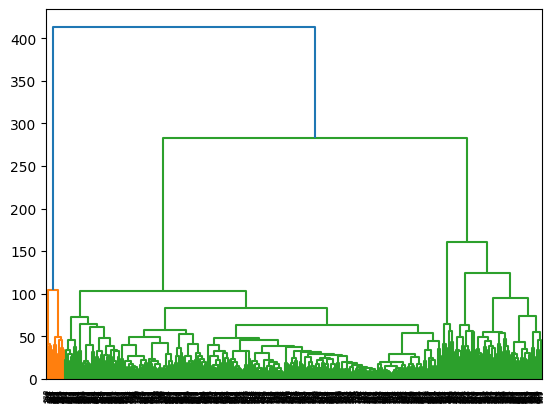

In [40]:
    tg_model = Triglav(n_jobs = 10, 
                       verbose = 0,
                       n_iter_fwer = 5,
                       p_1 = 0.70,
                       p_2 = 0.4,
                       transformer = CLRTransformer(),
                       run_stage_2 = True, 
                       alpha = 0.01,
                       metric = "euclidean", 
                       linkage = "ward")
        
    fig = tg_model.visualize_hclust(X_train, y_train)
    plt.show()
    plt.close()

#### Fit a Triglav Model using the threshold and save features belonging to the best scoring model

In [41]:
    best_features = None
    best_score = -1000
    best_model_sage = None
    best_feature_names = None
    
    splitter = StratifiedGroupKFold(n_splits = 5, random_state = 0, shuffle = True)
    for train, test in splitter.split(X_removed, y, groups):
        
        X_train = X_removed[train]
        y_train = y[train]
        
        X_test = X_removed[test]
        y_test = y[test]
        
        tg_model = Triglav(n_jobs = 10,
                           estimator = ExtraTreesClassifier(512, max_depth = 7, bootstrap = True),
                           verbose = 3,
                           n_iter_fwer = 5, # A lower value will result in a more conservative selection of clusters
                           p_1 = 0.70, # A higher value will result in a more conservative selection of clusters
                           p_2 = 0.4, # A higher value will result in more clusters being rejected
                           transformer = CLRTransformer(),
                           run_stage_2 = True, 
                           alpha = 0.01, # A lower value will result in a more conservative selection of clusters
                           metric = "euclidean", 
                           linkage = "ward",
                           thresh = 35) # This value will control the number of clusters.
        
        tg_model.fit(X_train, y_train)
        
        X_train_trf = clr(multiplicative_replacement(closure(X_train)))[:, tg_model.selected_]
        X_test_trf = clr(multiplicative_replacement(closure(X_test)))[:, tg_model.selected_]
        
        clf = ExtraTreesClassifier(512).fit(X_train_trf, y_train)
        score = balanced_accuracy_score(y_test, clf.predict(X_test_trf))
        
        print("The BAcc Score is: ", score)
        
        if score > best_score:
            best_score = score
            best_feature_names = reduced_features[tg_model.selected_]
            best_features = np.copy(tg_model.selected_best_, "C")
            best_model_sage = tg_model.sage_values_

Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 71 / Re

100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [05:44<00:00, 344.11s/it]


Final Feature Set Contains 160 Features.
Final Set of Best Features Contains 28 Features.
The BAcc Score is:  0.7833333333333333
Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 76 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 76 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 76 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 76 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 76 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 76 / Rejected: 0
Round 11 / Tentative 

100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [04:36<00:00, 276.48s/it]


Final Feature Set Contains 132 Features.
Final Set of Best Features Contains 31 Features.
The BAcc Score is:  0.95
Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 78 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 78 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 78 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 78 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 78 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 78 / Rejected: 0
Round 11 / Tentative (Accepted): 0 

100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [06:42<00:00, 402.73s/it]


Final Feature Set Contains 180 Features.
Final Set of Best Features Contains 35 Features.
The BAcc Score is:  0.9
Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 72 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 72 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 72 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 72 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 72 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 72 / Rejected: 0
Round 11 / Tentative (Accepted): 0 /

100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [04:53<00:00, 293.60s/it]


Final Feature Set Contains 138 Features.
Final Set of Best Features Contains 27 Features.
The BAcc Score is:  0.85
Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 70 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 70 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 70 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 70 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 70 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 70 / Rejected: 0
Round 11 / Tentative (Accepted): 0 

100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [07:25<00:00, 445.18s/it]


Final Feature Set Contains 198 Features.
Final Set of Best Features Contains 35 Features.
The BAcc Score is:  0.75


#### Visualize SAGE scores to get a sense of which ASVs are predictive

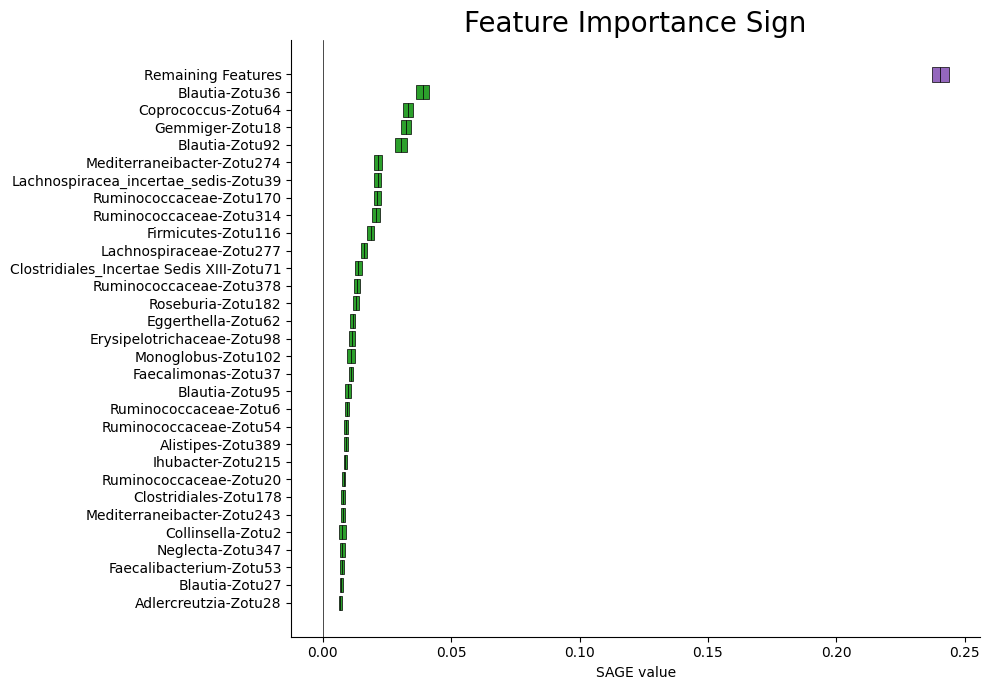

In [50]:
    best_model_sage.plot_sign(feature_names=best_feature_names, max_features = 30, tick_size = 10, label_size = 10)
    
    plt.show()
    plt.close()

#### It is important to note that SAGE scores only give us an understanding of which ASVs are important for classification on a global level. They do not (currently) help us understand how samples are placed on a local level or which features contribute to the variation along each axis. To understand this a TreeOrdination analysis would be useful. This analysis will produce an projection of the high-dimensional data and we can use this to plot analogues to loading scores for each of the projected axes.

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable


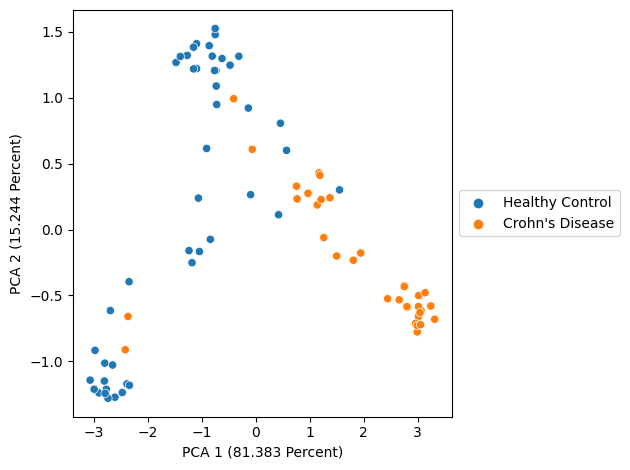

In [43]:
    from TreeOrdination import TreeOrdination
    
    tree_ord_model = TreeOrdination(metric="hamming",
                                    feature_names=reduced_features[best_features],
                                    unsup_n_estim=160,
                                    n_iter_unsup=5,
                                    n_jobs=10,
                                    max_samples_tree=100,
                                    clr_trf = True).fit(X_removed[:, best_features], y)
    
    # Plot data
    projection = tree_ord_model.emb_transform(X_removed[:, best_features])
    sns.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=y)

    pc1 = tree_ord_model.R_PCA.explained_variance_ratio_[0] * 100
    pc2 = tree_ord_model.R_PCA.explained_variance_ratio_[1] * 100
    plt.xlabel("PCA 1 (%.3f Percent)" % pc1)
    plt.ylabel("PCA 2 (%.3f Percent)" % pc2)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
    plt.close()

#### We will also test if significant differences exist between Crohn's Disease patients and healthy controls

In [44]:
    from skbio.stats.distance import permanova, DistanceMatrix
    from sklearn.metrics import pairwise_distances
    
    # Calculate distance matrix
    D_ij = pairwise_distances(projection, metric = "euclidean").astype(np.float32)
    
    D_ij = DistanceMatrix(D_ij)
    
    # PerMANOVA
    pmanova = permanova(D_ij, y, permutations = 999)
    
    pseudo_f, pval = pmanova.values[4:6]
    
    R2 = 1 - 1 / (
            1
            + pmanova.values[4]
            * pmanova.values[4]
            / (pmanova.values[2] - pmanova.values[3] - 1)
        )
    
    print("Pseudo-F = ", pseudo_f)
    print("p-value = ", pval)
    print("R-squared = ", R2)
    

Pseudo-F =  85.36742503432123
p-value =  0.001
R-squared =  0.9895445742227232


#### This analysis shows that a significant difference exists in the microbiomes of Crohn's Disease patients when compared to healthy controls. We can use the projection to determine the loading scores along each axis (x-axis below since it explains 98% of the variance between samples).

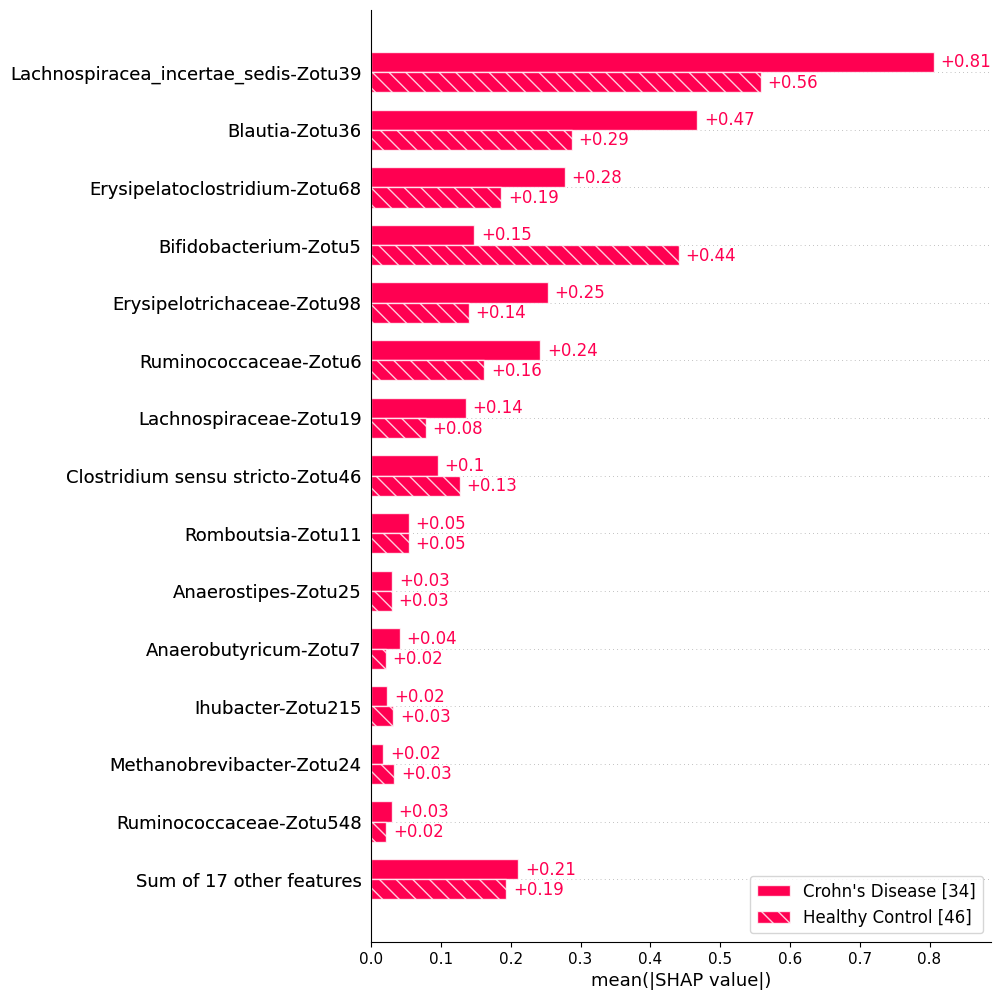

In [45]:
    predictive_model = tree_ord_model.l_model
    
    E = sh.Explainer(predictive_model, feature_names=reduced_features[best_features])
    shap_test = E(clr(multiplicative_replacement(closure(X_removed[:, best_features]))))
    
    sh.plots.bar(
                shap_test[:, :, 0].cohorts(y).abs.mean(0), max_display=15, show=False
            )

    plt.show()
    plt.close()


#### We can use the projection to determine what determines the locaton of each sample along the x-axis. The value on the left of the genus is the CLR-transformed abundance. f(x) is the location of the sample along the x-axis. Positive values (pink) push samples towards Crohn's disease while negative values (blue) push samples towards being a healthy control.

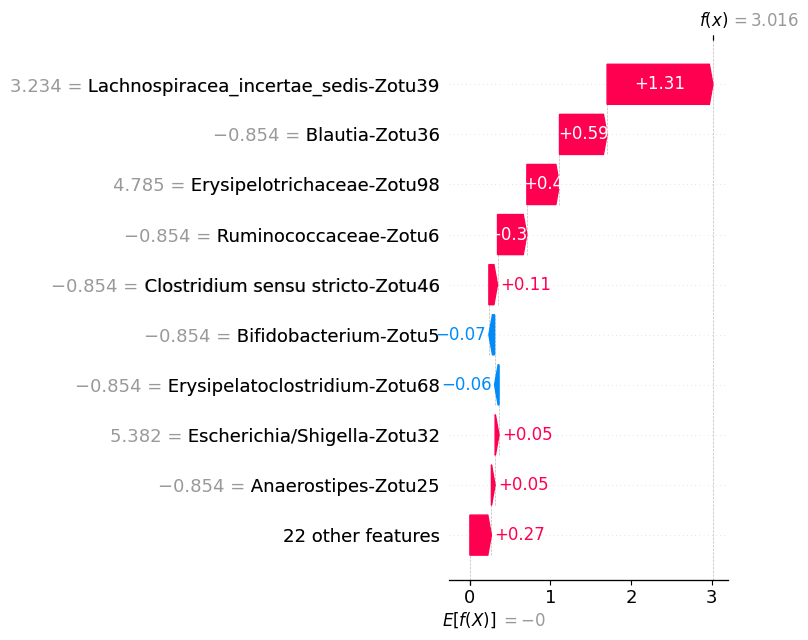

In [46]:
    cd_loc = np.where(y == "Crohn's Disease", True, False)
    
    sh.plots.waterfall(shap_test[cd_loc][0, :, 0], show=False)
    plt.tight_layout()
    plt.show()
    plt.close()

#### The same can also be done for healthy controls.

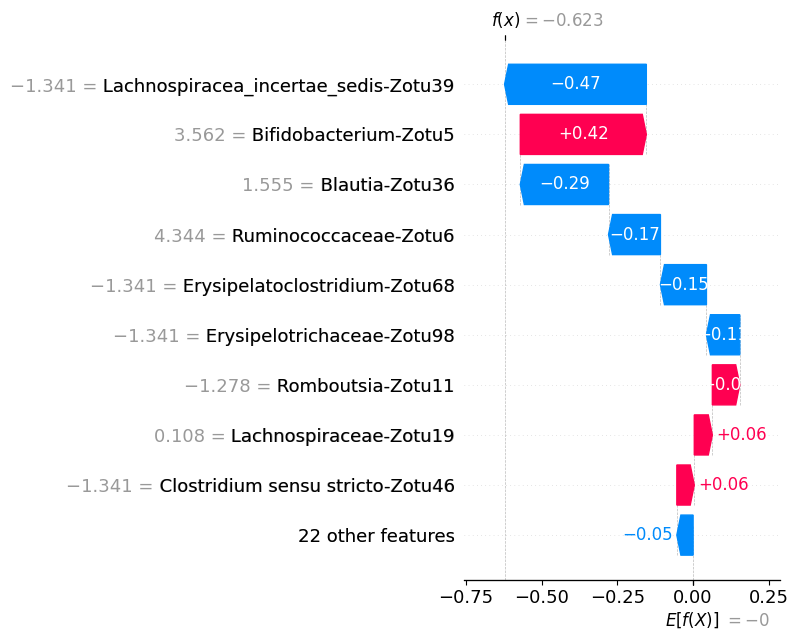

In [47]:
    hc_loc = np.where(y == "Crohn's Disease", False, True)
    
    sh.plots.waterfall(shap_test[hc_loc][0, :, 0], show=False)
    plt.tight_layout()
    plt.show()
    plt.close()

#### Finally, we can create a cluster map of the CLR-Transformed values. Red samples are Crohn's Disease patients while blue samples are healthy controls.

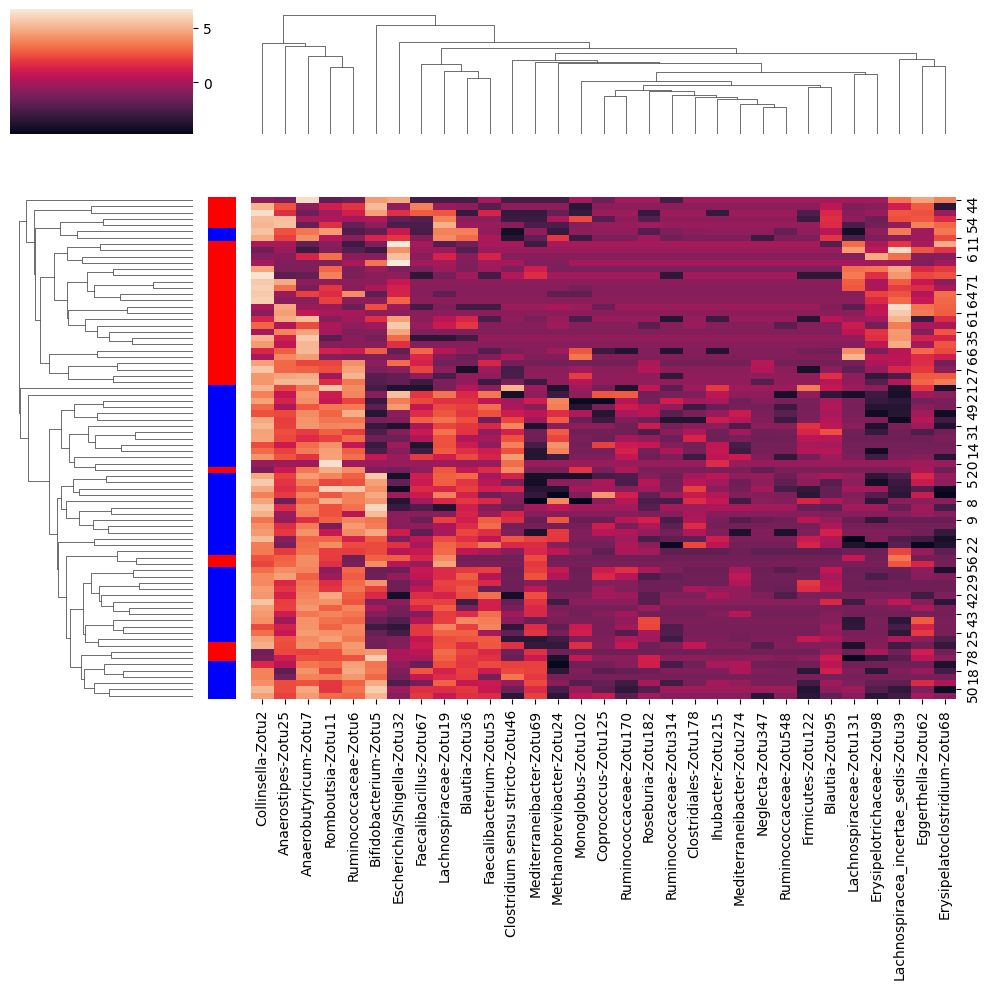

In [48]:
    patient_cols = ["r" if x == "Crohn's Disease" else "b" for x in y]

    sns.clustermap(pd.DataFrame(clr(multiplicative_replacement(closure(X_removed[:, best_features]))), 
                                columns = reduced_features[best_features]),
                   row_colors = patient_cols)

    plt.tight_layout()
    plt.show()
    plt.close()

#### References

Rudar, J., Porter, T.M., Wright, M., Golding G.B., Hajibabaei, M. LANDMark: an ensemble 
approach to the supervised selection of biomarkers in high-throughput sequencing data. 
BMC Bioinformatics 23, 110 (2022). https://doi.org/10.1186/s12859-022-04631-z

Pedregosa F, Varoquaux G, Gramfort A, Michel V, Thirion B, Grisel O, et al. Scikit-learn: 
Machine Learning in Python. Journal of Machine Learning Research. 2011;12:2825–30. 

Geurts P, Ernst D, Wehenkel L. Extremely Randomized Trees. Machine Learning. 2006;63(1):3–42.

Rudar, J., Golding, G.B., Kremer, S.C., Hajibabaei, M. (2023). Decision Tree Ensembles Utilizing 
Multivariate Splits Are Effective at Investigating Beta Diversity in Medically Relevant 16S Amplicon 
Sequencing Data. Microbiology Spectrum e02065-22.

Porter, T. M., & Hajibabaei, M. (2022). MetaWorks: A flexible, scalable bioinformatic pipeline for high-throughput multi-marker 
biodiversity assessments. PLOS ONE, 17(9), e0274260. doi: 10.1371/journal.pone.0274260

Wang, Q., Garrity, G. M., Tiedje, J. M., & Cole, J. R. (2007). Naive Bayesian Classifier for Rapid Assignment of rRNA Sequences into the New Bacterial Taxonomy. Applied and Environmental Microbiology, 73(16), 5261–5267. doi:10.1128/AEM.00062-07

Forbes JD, Chen C-Y, Knox NC, Marrie R-A, El-Gabalawy H, de Kievit T, et al. A comparative study of the gut microbiota in immune-mediated inflammatory diseases-does a common dysbiosis exist? Microbiome. 2018 Dec 13;6(1):221–221.

The scikit-bio development team (2020). scikit-bio: A Bioinformatics Library for Data Scientists, Students, and Developers. http://scikit-bio.org. version 0.5.8.